# Quantum-Classical Hybrid Computing: Components

These notebooks expand the content presented in the D-Wave webinar [Hybrid Quantum Programming](https://www.youtube.com/watch?v=EW44reo8Bn0), demonstrating how you can apply Leap's cloud-based hybrid solvers and Ocean software's *dwave-hybrid* solvers to your problem, create hybrid workflows, and develop custom hybrid components.

This **third** notebook examines and develops *dwave-hybrid* components:

1. [A Sample Problem](#A-Sample-Problem) section reproduces the  [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) example problem for use in this notebook.
2. [Working with Components](#Working-with-Components) section is a close look at hybrid components and their main methods.
3. [Developing and Modifying Components](#Developing-and-Modifying-Components) section demonstrates developing your own components to optimize performance.

More-basic content is provided in the previous notebooks:

* [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) notebook starts you off with Leap hybrid solvers and *dwave-hybrid* solvers and workflows.
* [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook shows how you create your own workflows using *dwave-hybrid* components. 

# A Sample Problem
This section recreates the [Quantum-Classical Hybrid Computing: Getting Started](01-hybrid-computing-getting-started.ipynb) problem for use in the following sections. 

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: Problem size (nodes and density of edges) selected below ensures that runtimes on compute resources (virtual CPUs) provided by the Leap environment do not exceed a few minutes.</div>

Loading BokehJS ...

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


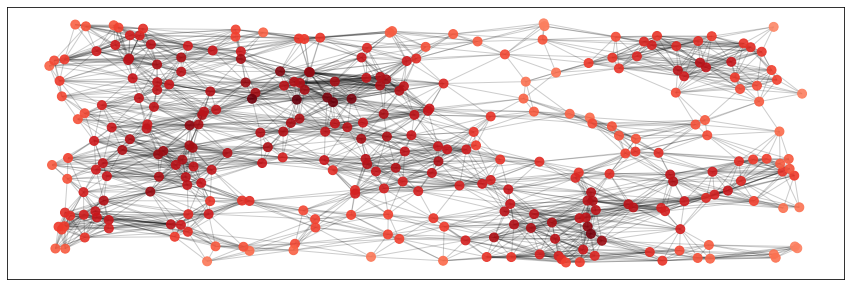

In [1]:
import matplotlib.pyplot as plt
from helpers.draw import plot 
%matplotlib inline
import networkx as nx
import dwave_networkx as dnx
import dimod
import numpy as np

problem_node_count = 300

G = nx.random_geometric_graph(problem_node_count, radius=0.0005*problem_node_count)

qubo = dnx.algorithms.independent_set.maximum_weighted_independent_set_qubo(G)
bqm = dimod.BQM.from_qubo(qubo)

plot(G)

# Working with Components

*dwave-hybrid* provides a variety of components that enable you to build workflows optimized for your problem. For many problems, using just these components is sufficient. This section examines these components and their methods to help you best exploit them and to provide a foundation for section [Developing and Modifying Components](#Developing-and-Modifying-Components).

## States
[State](https://docs.ocean.dwavesys.com/projects/hybrid/reference/core.html) is a subclass of a *dwave-hybrid* class, *PliableDict*, which extends the [dict](https://docs.python.org/3/library/stdtypes.html#dict) class with attribute accessors acting as item accessors. It is used to pass computation states to and from components and typically contains at least *samples* and *problem* fields. As you saw in the [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook, standard *dwave-hybrid* Runnables add fields such as *subproblem* and *subsamples* when decomposing problems, and you can add custom fields of your own. 

A closely related class, [States](https://docs.ocean.dwavesys.com/projects/hybrid/reference/core.html), is a list of state objects. It is used, for example, to hold the multiple states produced by a workflow's parallel branches.   

### Creating States
*dwave-hybrid* provides several utility methods for creating states. Because Runnable components require an input state, you typically need to provide some initial state to your workflows. 

Create a state from the example problem. The *problem* field is a [dimod](https://docs.ocean.dwavesys.com/projects/dimod/index.html) binary quadratic model ([BQM](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/bqm/binary_quadratic_model.html)) and the *samples* field is a subclass of the *dimod* [SampleSet](https://docs.ocean.dwavesys.com/projects/dimod/reference/sampleset.html). 

In [2]:
import hybrid

state = hybrid.State.from_problem(bqm)
print("Field problem is of type: {}\nField samples is of type: {}".format(
       type(state.problem), type(state.samples)))

Field problem is of type: <class 'dimod.binary_quadratic_model.BinaryQuadraticModel'>
Field samples is of type: <class 'hybrid.core.SampleSet'>


You can set samples' values&mdash;for some initial samples you may be in a position to provide values you know are better than zeros or random for your problem; for example, if you are intermittently running a very large problem, possibly on more than one solver, and saving intermediate results. 

Here, for simplicity, `max_sample` is used to set values.

In [3]:
state = hybrid.State.from_sample(hybrid.max_sample(bqm), bqm)
print("Initial state's sampleset has energy {}.".format(state.samples.first.energy))

Initial state's sampleset has energy 5210.0.


### Updating States
The *updated()* method, which you saw demonstrated in the [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook through Runnable [Lambda](https://docs.ocean.dwavesys.com/projects/hybrid/reference/flow.html), returns a deep copy of the state updated by specified arguments.  

In [4]:
state_info = state.updated(info="Some information")
print("Content of info field: {}.".format(state_info.info))

Content of info field: Some information.


The method can also update the States class. Runnable `Dup` duplicates `n` times an input state to an output States class.  

In [5]:
states_info = hybrid.Dup(2).run(state_info).result()

states_info2 = states_info.updated(info2="Some more information")

for s in states_info2:
    print("Content of info2 field: {}.".format(s.info2))

Content of info2 field: Some more information.
Content of info2 field: Some more information.


### Resolving States
States created by Runnables are held in [Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future)-like objects. By default, hybrid components use *hybrid.concurrency.thread_executor* to create an asynchronous call. The *result()* method implements `concurrent.Future`-compatible result resolution. 

While the loop below iterates `max_iter` times on Runnable `Identity`, which copies its input state to its output state, the output state is a Future with status "running". Once execution terminates, the status changes to "finished".  

In [6]:
from time import sleep

output_state = hybrid.Loop(hybrid.Identity(), max_iter=50).run(state)

print("State during execution: {}.".format(output_state))
sleep(3)
print("State after execution: {}.".format(output_state))

State during execution: <Future at 0x12747a810 state=running>.
State after execution: <Future at 0x12747a810 state=finished returned State>.


Trying to access the output state directly raises an error. Use the *result()* method to retrieve the encapsulated output state from the Future.

In [7]:
try:
    print(output_state.samples.first.energy)
except AttributeError as err:
    print("Accessing state before resolution: {}.".format(err))

output_state = output_state.result()
print("Accessing state after resolution: {}.".format(output_state.samples.first.energy))

Accessing state before resolution: 'Future' object has no attribute 'samples'.
Accessing state after resolution: 5210.0.


Runnables are by default asynchronous, but you can specify a blocking call. For a blocking call, the state is returned in a [Present](https://docs.ocean.dwavesys.com/projects/hybrid/reference/core.html) class, which is a `Future` resolved at construction time. 

Run `Identity` in a loop again, but as a blocking call. The `print` command cannot execute until execution terminates, with the status of the Present containing the output state set to "finished".  

In [8]:
output_state = hybrid.Loop(hybrid.Identity(), max_iter=300).run(state, 
                                    executor=hybrid.immediate_executor)

output_state = output_state.result()
print("After termination and resolution: {}.".format(output_state.samples.first.energy))

After termination and resolution: 5210.0.


## Runnables
[Runnable](https://docs.ocean.dwavesys.com/projects/hybrid/reference/core.html) is the key superclass in *dwave-hybrid*: all basic components&mdash;samplers, decomposers, composers&mdash;and flow-structuring components such as branches inherit from this class. 

A Runnable executes for an iteration in which it updates the state it receives. Its main methods are `run` or `next` to execute an iteration and `stop` to terminate the Runnable.

### Executing Runnables
By this point you have run a number of components using the *run()* method. Runnable class's *run()* handles some housekeeping work and passes the Future-encapsulated input state to the *dispatch()* method for resolution. This dispatcher does some verification and passes the state to either *error()* method to handle resolution errors or to *next()* method.

By default, *error()* method just raises the exception. In the [Developing and Modifying Components](#Developing-and-Modifying-Components) section you will overwrite the base Runnable *error()* method to customize error handling.

In [9]:
invalid_state_in_future = hybrid.Identity().run(1)

try:
    hybrid.Dup(2).dispatch(invalid_state_in_future)
except Exception as exc:
    print("Default error handling raises message: {}.".format(exc))

Default error handling raises message: 'int' object has no attribute 'result'.


The *next()* method executes one blocking iteration of an instantiated Runnable with a valid state as input. In the [Developing and Modifying Components](#Developing-and-Modifying-Components) section you will overwrite the base Runnable *next()* method to customize your own components.

In [10]:
output_state = hybrid.Identity().next(state)

print("Energy: {}.".format(state.samples.first.energy))

Energy: 5210.0.


Note that in contrast to *run()*, which inputs a Future, the input to *next()* is a state resolved and validated by *dispatch()*.

### Terminating Runnables
Runnable components might not terminate on their own; for example, your workflow might run a non-terminating sampler or a loop without terminating conditions. In such cases, your workflow will use the *stop()* method to terminate execution. (Note that not all components are interruptible.)   

In [11]:
workflow = hybrid.Loop(hybrid.Identity())

output_state = workflow.run(state)

sleep(0.2)
print("Workflow after run(): {}.".format(output_state))
workflow.stop()
sleep(0.2)
print("Workflow after stop(): {}.".format(output_state))

Workflow after run(): <Future at 0x127497310 state=running>.
Workflow after stop(): <Future at 0x127497310 state=finished returned State>.


The base Runnable *stop()* method calls the *halt()* method, which is not implemented by the base Runnable itself. As you will do in the [Developing and Modifying Components](#Developing-and-Modifying-Components) section, Runnable components overwrite the *halt()* method.

In [12]:
workflow = hybrid.Loop(hybrid.Identity())

output_state = workflow.run(state)

workflow.halt()
sleep(0.2)
print("Workflow after halt(): {}.".format(output_state))

Workflow after halt(): <Future at 0x1271996d0 state=finished returned State>.


# Developing and Modifying Components
Although *dwave-hybrid* provides a variety of components, some problems can benefit from non-standard processing or you might have fresh ideas on ways to solve a problem. This section demonstrates how to write new hybrid components and modify existing components. 

## A Simple Runnable
You can create a simple hybrid component of your own by overwriting the Runnable base class's *next()* method, which executes one blocking iteration of an instantiated Runnable with a valid state as input.  

`IncrementCount` is a very simple example: it updates a counter in its input state, similar to such updates that the [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook demonstrated using Runnable `Lambda`. 

In [13]:
class IncrementCount(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)

Set an initial value for the `counter` field and instantiate and execute your simple component. In the [Adding Custom Traits](#Adding-Custom-Traits) subsection below, you will see how to ensure the input state contains any such required field.

In [14]:
state_count_0 = state.updated(counter=0)

output_state = IncrementCount().run(state_count_0).result()
print("Counter field value after one execution: {}.".format(output_state.counter))

Counter field value after one execution: 1.


<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> In the placeholder code cell below, modify `IncrementCount` to also print the state's best energy. Test your code in the EXERCISE TEST CELL below.
<p>Note: a *samples* field is present in the tested input state, `state_count_0`, and for simplicity, assume this is always the case. In the [Adding Custom Traits](#Adding-Custom-Traits) subsection below, you will see how to ensure this is always the case.</p></div>

In [15]:
# Placeholder cell for exercise code. Modify the code lines below:

class IncrementCountPrintEnergy(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)

In [16]:
class IncrementCountIncrementCountPrintEnergy(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        print("Best energy in current state is {}.".format(state.samples.first.energy))
        return state.updated(counter=state.counter+1)

In [17]:
# EXERCISE TEST CELL

output_state = IncrementCountIncrementCountPrintEnergy().run(state_count_0).result()
print("Counter field value after one execution: {}.".format(output_state.counter))

Best energy in current state is 5210.0.
Counter field value after one execution: 1.


## Customizing Termination
The `@stoppable` [decorator](https://www.python.org/dev/peps/pep-0318/) extends Runnable subclasses with a `stop_signal` [semaphore/event](https://docs.python.org/2/library/threading.html). 

The `IncrementCountSeconds` example Runnable increments a counter in its input state every second for up to 10 seconds, unless terminated by *stop()*. 

In [18]:
import time

@hybrid.stoppable
class IncrementCountSeconds(hybrid.Runnable):
    """An example Runnable that increments a counter every second."""

    def next(self, state, **kwargs):
        cnt = state.counter
        t0 = time.time()
        self.stop_signal.wait(timeout=10)
        cnt += time.time() - t0
        return state.updated(counter=int(cnt))

Your Runnable inherits the base *stop()* and *halt()* methods for termination. Run `IncrementCountSeconds` but terminate in less than 10 seconds. 

In [19]:
workflow = IncrementCountSeconds()

output_state = workflow.run(state_count_0)

sleep(2)
workflow.stop()

print("Counter is now {}.".format(output_state.result().counter))

Counter is now 2.


Runnable `Loop` implements the `@stoppable` decorator and can be terminated. 

In [20]:
workflow = hybrid.Loop(IncrementCount())

output_state = workflow.run(state_count_0)

sleep(0.5)
workflow.stop()
print("Counter is now {}.".format(output_state.result().counter))

Counter is now 19.


If you need to implement a custom termination of your Runnable, overwrite the base *halt()* method, which is called by *stop()* for that purpose, rather than the *stop()* method. 

In [21]:
class IncrementCount(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)
    
    def halt(self):
        print("\nTerminated.\n")

In [22]:
workflow = hybrid.Loop(IncrementCount())

output_state = workflow.run(state_count_0)

sleep(0.5)
workflow.stop()
print("Counter is now {}.".format(output_state.result().counter))


Terminated.

Counter is now 23.


<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Modify `IncrementCount` below to automatically print the counter value when terminated. Test your code in the EXERCISE TEST CELL below.
<p>Note: Although your component does not accept parameters, the placeholder code's Runnable base initialization includes the `**runopts**` parameter.</p></div>

In [23]:
# Write your exercise code here:

class IncrementCount(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""

    def __init__(self, **runopts):
        super(IncrementCount, self).__init__(**runopts)
        self.count = 0

    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)
    
    def halt(self):
        print("\nTerminated.\n")

In [24]:
class IncrementCount(hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""

    def __init__(self, **runopts):
        super(IncrementCount, self).__init__(**runopts)
        self.count = 0

    def next(self, state, **kwargs):
        self.count = state.counter+1
        return state.updated(counter=self.count)
    
    def halt(self):
        print("\nTerminated with counter = {}.\n".format(self.count))

In [25]:
# EXERCISE TEST CELL
workflow = hybrid.Loop(IncrementCount())

output_state = workflow.run(state_count_0)

sleep(0.2)
workflow.stop()


Terminated with counter = 15.



## Specifying Traits

State [traits](https://docs.ocean.dwavesys.com/projects/hybrid/reference/traits.html) are verified for all Runnable objects that inherit from *StateTraits* or its subclasses. Traits of a new Runnable must be expressed and modified at construction time by its parent. When developing new Runnable classes, constructing composite traits can be nontrivial for some advanced flow-control Runnables.

### Example Trait: SISO
Your simple Runnable can only process a single-state input. A complex workflow might incorrectly provide it with a `States` input, in which case the error message to the user might be confusing. 

Try running `IncrementCount` on a *States*-class object:

In [26]:
states_count_0 = hybrid.States(state_count_0, state_count_0)

try:
    output_states = IncrementCount().run(states_count_0).result()
except Exception as exc:
    print("Low-level error message: {}.".format(exc))

Low-level error message: 'States' object has no attribute 'counter'.


Add the trait `SISO` (single input, single output) to the Runnable to validate the input.

In [27]:
class IncrementCount(hybrid.traits.SISO, hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)
    
    def halt(self):
        print("\nTerminated.\n")

Try running `IncrementCount` with the SISO trait on a *States*-class object:

In [28]:
try:
    output_states = IncrementCount().run(states_count_0).result()
except hybrid.exceptions.StateDimensionalityError as exc:
    print("High-level error message: {}.".format(exc))
except Exception as exc:
    print("Low-level error message: {}.".format(exc))

High-level error message: single state required on input to IncrementCount().


### Example Trait: MIMO

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Exercise:</b> Modify `IncrementCount` from inheriting the SISO trait to inheriting the MIMO (multiple input, multiple output) trait and test it in the EXERCISE TEST CELL below.
</div>

In [29]:
# Write your exercise code here:

class IncrementCountMIMO(hybrid.traits.MIMO, hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)
    
    def halt(self):
        print("\nTerminated.\n")

In [30]:
class IncrementCountMIMO(hybrid.traits.MIMO, hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, states, **kwargs):
        for i in range(len(states)):
            states[i] = states[i].updated(counter=states[i].counter+1)
        return states
    
    def halt(self):
        print("\nTerminated\n")

Test your exercise solution by running the next cell, which uses `IncrementCount` on a *States*-class object:

In [31]:
#EXERCISE TEST CELL
from random import randint

# test case: input MIMO (should work)
print("Test MIMO:")

states_count_initial = hybrid.States(state_count_0.updated(counter=randint(0, 10)), 
                                     state_count_0.updated(counter=randint(0, 10)))

try:
    output_states = IncrementCountMIMO().run(states_count_initial).result()
    for ind, s in enumerate(output_states):
        print("Counter value of state {} is {}.".format(ind, s.counter))
except hybrid.exceptions.StateDimensionalityError as exc:
    print("High-level error message: {}.".format(exc))
except Exception as exc:
    print("Low-level error message: {}.".format(exc))
    
# test case: input SISO (should give error)
print("\nTest SISO:")

try:
    output_states = IncrementCountMIMO().run(state_count_0).result()
    print("Counter value is {}.".format(output_states.counter))
except hybrid.exceptions.StateDimensionalityError as exc:
    print("High-level error message: {}.".format(exc))
except Exception as exc:
    print("Low-level error message: {}.".format(exc))

Test MIMO:
Counter value of state 0 is 11.
Counter value of state 1 is 2.

Test SISO:
High-level error message: state sequence required on input to IncrementCountMIMO().


## Adding Custom Traits

The hybrid framework makes it easy to add your own traits. 

### Example: Existing Trait SamplesProcessor

The `SamplesProcessor` trait requires that the Runnable input samples and output samples. It does so by simply specifying two existing traits: 

`class SamplesProcessor(SamplesIntaking, SamplesProducing):
     pass`

The `SamplesIntaking` trait, for example, simply adds "samples" to the list of validated traits by the `InputValidated` trait:

`class SamplesIntaking(InputValidated, StateTraits):
    def __init__(self):
        super(SamplesIntaking, self).__init__()
        self.inputs.add('samples')`

You can see how it works by adding it to a tabu search:

In [32]:
class TabuProblemSamplerInitialized(hybrid.traits.SamplesProcessor, 
                                    hybrid.traits.ProblemSampler, 
                                    hybrid.traits.SISO, 
                                    hybrid.Runnable):
    """A tabu search with the SamplesProcessor state trait."""
    
    def next(self, state, **kwargs):
        samples = hybrid.TabuProblemSampler().run(state).result().samples
        return state.updated(samples=samples)   

The following test artificially removes the `samples` field from the input state. 

In [33]:
# test case: input state has samples should work
print("Test with samples:")

state = hybrid.State.from_problem(bqm)

try:
    output_states = TabuProblemSamplerInitialized().run(state).result()
    print("works.")
except Exception as exc:
    print("Low-level error message: {}.".format(exc))
    
# test case: input state has no samples should give error
print("Test without samples:")

del state['samples']

try:
    output_states = TabuProblemSamplerInitialized().run(state).result()
    print("Works.")
except hybrid.exceptions.StateTraitMissingError as exc:
    print("High-level error message: {}.".format(exc))
except Exception as exc:
    print("Low-level error message: {}.".format(exc))

Test with samples:
works.
Test without samples:
High-level error message: input state is missing 'samples' on TabuProblemSamplerInitialized().


### Example: New Trait TraitCounterIntaking
In previous subsections, you used fields in the input state such as `info` or `counter`, relying on the user to initialize the state with the required field. Now you know how to ensure any fields you require are there: define a subclass of `InputValidated` that adds the required field and inherit your new trait in your component. 

In [34]:
class TraitCounterIntaking(hybrid.traits.InputValidated, hybrid.traits.StateTraits):
    def __init__(self):
        super(TraitCounterIntaking, self).__init__()
        self.inputs.add('counter')

class IncrementCount(TraitCounterIntaking, 
                     hybrid.traits.SISO, 
                     hybrid.Runnable):
    """An example Runnable that increments a counter in the input state."""
    
    def next(self, state, **kwargs):
        return state.updated(counter=state.counter+1)

In [35]:
try:
    output_states = IncrementCount().run(state).result()
except hybrid.exceptions.StateTraitMissingError as exc:
    print("High-level error message: {}.".format(exc))
except Exception as exc:
    print("Low-level error message: {}.".format(exc))

High-level error message: input state is missing 'counter' on IncrementCount().


## A Custom Sampler

Consider again an example where G represents a sprinkler system and you build a hybrid workflow that finds which sprinklers to use to water a lawn evenly with the lowest number of sprinklers. Say that at some mid-point in your workflow some sprinklers are marked as defective in the input state to a branch that runs tabu search.

<div class="alert alert-success" role="alert" style="margin: 10px"> 
    <b>Summary Exercise:</b> Customize a sampler that uses TabuProblemSampler but checks its best solution against a list of specified sprinklers in the state's "info" field, as shown in the EXERCISE TEST CELL below. It updates that field if those sprinklers are selected. 
</div>    

In [36]:
# Write your exercise code here:

class TabuProblemSamplerFilteredNodes(hybrid.traits.ProblemSampler, 
                                      hybrid.traits.SISO, 
                                      hybrid.Runnable):
    """A tabu search that marks samples that select specified nodes."""
    
    def next(self, state, **kwargs):
        samples = hybrid.TabuProblemSampler().run(state).result().samples
        pass   

In [37]:
class TraitInfoIntaking(hybrid.traits.InputValidated, hybrid.traits.StateTraits):
    def __init__(self):
        super(TraitInfoIntaking, self).__init__()
        self.inputs.add('info')


class TabuProblemSamplerFilteredNodes(TraitInfoIntaking, 
                                      hybrid.traits.ProblemSampler, 
                                      hybrid.traits.SISO, 
                                      hybrid.Runnable):
    """A tabu search that marks samples that select specified nodes."""

    def next(self, state, **kwargs):
        info = state.info
        info["filtered nodes selected"] = False
        
        samples = hybrid.TabuProblemSampler().run(state).result().samples
        best_sample = samples.first.sample
        
        for node, val in best_sample.items(): 
            if node in state.info["filter nodes"] and val==1:
                info["filtered nodes selected"] = True
                break       
                
        return state.updated(samples=samples, info=info)

Here, the input state to `TabuProblemSamplerFilteredNodes` is set to specify two random sprinklers:

In [38]:
#EXERCISE TEST CELL
state_filtered_nodes = state.updated(info={"filter nodes": list(np.random.randint(0, problem_node_count, 2))})

output_state = TabuProblemSamplerFilteredNodes().run(state_filtered_nodes).result()

print(output_state.info)

{'filter nodes': [224, 237], 'filtered nodes selected': False}


You now have enough familiarity with *dwave-hybrid* to start experimenting on your own. When building new components, reference the source code directly for up-to-date information and helpful inline comments written for developers. 

Satisfied with your new component? Share it with the community by making a pull request to https://github.com/dwavesystems/dwave-hybrid. 

Have a great idea and need some implementation advice or assistance? Post it to the [Leap community](https://support.dwavesys.com/hc/en-us/community/topics).

# Dimod Conversion
*dwave-hybrid* provides classes that convert between hybrid and [dimod](https://docs.ocean.dwavesys.com/projects/dimod/index.html) samplers. 

In the [Quantum-Classical Hybrid Computing: Workflows](02-hybrid-computing-workflows.ipynb) notebook you built a hybrid workflow that runs tabu and simulated annealing in parallel. 

In [39]:
workflow = (hybrid.Parallel(hybrid.TabuProblemSampler(num_reads=2, timeout=10),
            hybrid.SimulatedAnnealingProblemSampler(num_reads=1)) |
            hybrid.ArgMin() )

state_updated = workflow.run(state).result()
print("Updated state has {} sample sets with lowest energy {}.".format(
       len(state_updated.samples), state_updated.samples.first.energy))

Updated state has 2 sample sets with lowest energy -38.0.


The `HybridSampler` class enables you to convert a Runnable, in this case a workflow, into a dimod sampler: 

In [40]:
dimod_sampler = hybrid.HybridSampler(workflow)

Run the converted workflow. Remember that *dimod* samplers input a BQM, not a state. Here, the original problem BQM is provided:

In [41]:
solution = dimod_sampler.sample(bqm)
print("Best energy found is {}.".format(solution.first.energy))

Best energy found is -39.0.


You can also convert your custom components. The `TabuProblemSamplerFilteredNodes` below recodes the previous example&mdash;it checks its best solution against a list of specified sprinklers and notifies the user if those sprinklers are selected&mdash;but this time accepts a list of nodes as a runtime parameter. 

In [42]:
class TabuProblemSamplerFilteredNodes(hybrid.traits.ProblemSampler, 
                                      hybrid.traits.SISO, 
                                      hybrid.Runnable):
    """A tabu search that marks samples that select specified nodes."""
    
    def next(self, state, filter_nodes=[], **runopts):
        state = state.updated(info={"filter nodes":filter_nodes})
        state.info["filtered nodes selected"] = False
        
        samples = hybrid.TabuProblemSampler().run(state).result().samples
        best_sample = samples.first.sample
        
        for node, val in best_sample.items(): 
            if node in state.info["filter nodes"] and val==1:
                state.info["filtered nodes selected"] = True
                break 
                
        return state.updated(samples=samples, info=state.info)

You can execute this hybrid Runnable subclass on a given state, specifying the selected nodes in the `filter_nodes` argument:

In [43]:
selected_nodes = list(np.random.randint(0, problem_node_count, 2))

output_state = TabuProblemSamplerFilteredNodes().run(state, filter_nodes=selected_nodes).result()
print(output_state.info)

{'filter nodes': [152, 286], 'filtered nodes selected': False}


Or use the `HybridSampler` class to convert your Runnable into a dimod sampler: 

In [44]:
dimod_sampler = hybrid.HybridSampler(TabuProblemSamplerFilteredNodes())

Run the converted `TabuProblemSamplerFilteredNodes`. Setting the `return_state` parameter to True copies the final state, with its updated `info` field, into the `info` field of the returned *SampleSet*. 

In [45]:
solution = dimod_sampler.sample(bqm, filter_nodes=[2, 9, 6], return_state=True)
print(solution.info["state"]["info"])

{'filter nodes': [2, 9, 6], 'filtered nodes selected': True}
